(chap:9-multiple)=
# 重回帰分析

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import wooldridge
from numba import njit
from pandas.plotting import scatter_matrix
from scipy.stats import norm, uniform, gaussian_kde, multivariate_normal
from see import see
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

## 説明

```{margin}
<div name="html-admonition">
Do you want to read in a differnt language? Open the 
<input type="button" onclick="location.href='https://translate.google.com/translate?hl=&sl=ja&tl=en&u='+window.location;" value="Google translated version" style="color:#ffffff;background-color:#008080;" onmouseover="this.style.background='#99ccff'" onmouseout="this.style.background='#008080'"/>
in English or the language of your choice.
</div>
```

説明変数が複数の重回帰分析（Multiple Regression）を考える。

$$y_i=\beta_0+\sum_{j=1}^k\beta_j x_{ij} + u_i$$
* $i=1,2,...n$：観測値のインデックス
* $j=1,2,...k$：説明変数の数

（注意）

$x_1$と書く場合，$x_{i1},x_{i1},...x_{n1}$を表す（第１番目の説明変数）。

一般的に$x_j$と書く場合，$x_{ij},x_{ij},...x_{nj}$を表す（第$j$番目の説明変数）。

## `statsmodels`を使う

### 推定

単回帰分析で使った同じデータセット`wage1`を使い，賃金と教育の関係を再考する。[前章](chap:8-simple)と異なる点は，複数の説明変数を導入し重回帰分析をおこなうことである。追加的な説明変数として次の変数を加える。
* `exper`：潜在的な経験年数（＝年齢ー最高学歴までの年数ー６）
* `tenure`：現在の職場での在職年数

`statsmodels`を使う上で単回帰と異なる点は，それぞれの説明変数の前に`+`を追加するだけである。

まず必要な変数だけを取り出し変数`wage1`に割り当てる。

In [2]:
wage1 = wooldridge.data('wage1').loc[:,['wage', 'educ', 'tenure', 'exper']]

In [3]:
wooldridge.data('wage1',description=True)

name of dataset: wage1
no of variables: 24
no of observations: 526

+----------+---------------------------------+
| variable | label                           |
+----------+---------------------------------+
| wage     | average hourly earnings         |
| educ     | years of education              |
| exper    | years potential experience      |
| tenure   | years with current employer     |
| nonwhite | =1 if nonwhite                  |
| female   | =1 if female                    |
| married  | =1 if married                   |
| numdep   | number of dependents            |
| smsa     | =1 if live in SMSA              |
| northcen | =1 if live in north central U.S |
| south    | =1 if live in southern region   |
| west     | =1 if live in western region    |
| construc | =1 if work in construc. indus.  |
| ndurman  | =1 if in nondur. manuf. indus.  |
| trcommpu | =1 if in trans, commun, pub ut  |
| trade    | =1 if in wholesale or retail    |
| services | =1 if in services indus.  

被説明変数に対数賃金を使うために、新たな列`wage_log`を追加する

In [4]:
wage1['wage_log'] = np.log(wage1['wage'])

回帰式では追加の説明変数の前に`+`を付ける。

In [5]:
formula_1 = 'wage_log ~ educ + tenure + exper'

推計結果を変数`res_1`に割り当てる。

In [6]:
res_1 = ols(formula_1, data=wage1).fit()

[単回帰分析](sec:8-statsmodels)で説明したが，次のコードで結果を表にまとめて表示することができる。（関数`print()`を使っているが使わなくても同じ情報が表示される。）

In [7]:
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:               wage_log   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     80.39
Date:                Wed, 08 Mar 2023   Prob (F-statistic):           9.13e-43
Time:                        22:23:07   Log-Likelihood:                -313.55
No. Observations:                 526   AIC:                             635.1
Df Residuals:                     522   BIC:                             652.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2844      0.104      2.729      0.0

### 属性とメソッド

推定結果`res_1`の属性とメソッドは`dir()`や`see()`で確認できる。以下では`see()`を使う。

In [8]:
see(res_1)

    <                    <=                   ==                   !=
    >                    >=                   dir()                hash()
    help()               repr()               str()                .HC0_se
    .HC1_se              .HC2_se              .HC3_se              .aic
    .bic                 .bse                 .centered_tss
    .compare_f_test()    .compare_lm_test()
    .compare_lr_test()                        .condition_number    .conf_int()
    .conf_int_el()       .cov_HC0             .cov_HC1             .cov_HC2
    .cov_HC3             .cov_kwds            .cov_params()        .cov_type
    .df_model            .df_resid            .diagn               .eigenvals
    .el_test()           .ess                 .f_pvalue            .f_test()
    .fittedvalues        .fvalue              .get_influence()
    .get_prediction()    .get_robustcov_results()
    .info_criteria()     .initialize()        .k_constant          .llf
    .load()              .model  

単回帰分析と同様に、係数の推定値は属性`.params`で取得できる。

In [9]:
res_1.params

Intercept    0.284360
educ         0.092029
tenure       0.022067
exper        0.004121
dtype: float64

`res_1`は`Series`なので、インデックスを使って`educ`の係数だけを取り出す場合は次のようにする。

In [10]:
res_1.params[1]

0.0920289867692833

次に，メソッド`predict()`を使って予測値を計算してみよう。次の例では，`educ`, `tenure`, `exper`の平均値での`np.log(wage)`を計算する。

In [11]:
wm = wage1.mean()  # 変数の平均の計算
wm

wage         5.896103
educ        12.562738
tenure       5.104563
exper       17.017110
wage_log     1.623268
dtype: float64

`wm`は`Series`なので、変数の行ラベルを使い`wm['educ']`で`educ`の平均値だけを取り出すことができる。

In [12]:
wm['educ']

12.562737642585551

`predict()`に渡す引数としては，説明変数の辞書を作るのが一番簡単であろう。

In [13]:
z = {'educ':wm['educ'],
     'tenure':wm['tenure'],
     'exper':wm['exper']}

In [14]:
res_1.predict(z)

0    1.623268
dtype: float64

３つの変数が平均値を取る場合の平均時給の対数値は約1.62である。

複数の予測値を計算するには、辞書の値に`list`や`array`を書き込めば良い。次の例では、`tenure`と`exper`を平均値に固定し、`educ`を平均値、平均値-1、平均値+1に変化させて予測値を計算している。

In [15]:
educ_mean = wm['educ']
tenure_mean = wm['tenure']
exper_mean = wm['exper']

z2 = {'educ':[educ_mean-1, educ_mean, educ_mean+1],
                  'tenure':[tenure_mean]*3,
                  'exper':[exper_mean]*3}

educ_return = res_1.predict(z2)
educ_return

0    1.531239
1    1.623268
2    1.715297
dtype: float64

３つの変数が平均の値を取る場合，平均賃金の対数値は1.623268であり，上の計算と同じになることが確認できる。教育年数が1年減少すると予測値は1.531239であり，教育年数が1年増えると予測値は2.201336となる。この結果を使い，教育年数が一年変化する場合の影響を計算してみよう。まず教育年数が1年減少すると場合を計算しよう。

In [16]:
educ_return[0]-educ_return[1]

-0.0920289867692834

次に教育年数が1年増える場合を計算しよう。

In [17]:
educ_return[2]-educ_return[1]

0.09202898676928317

これらの数字の絶対値は同じである。この結果は偶然ではない。他の要因を固定し教育年数が1年変化（減少もしくは増加）した場合，平均時給の対数値がどれだけ変化したかを計算している。これは正しく教育の収益率である。この点を数式で確認するために，変数$x$の値が小さい場合（例えば，0.02），次の近似が成立することを思い出そう。

$$
\log(x+1)\approx x
$$ (eq:9-approx)

また教育年数が$h$の場合の平均時給を$w(h)$としよう。教育年数が一年増えた場合の教育の収益率は$\dfrac{w(h+1)-w(h)}{w(h)}$となり，[](eq:9-approx)を使うと次のように書くことができる。

$$
\begin{align*}
\frac{w(h+1)-w(h)}{w(h)}
&\approx\log\left(\frac{w(h+1)-w(h)}{w(h)}+1\right)\\
&=\log\left(\frac{w(h+1)}{w(h)}\right)\\
&=\log(w(h+1))-\log(w(h))
\end{align*}
$$ (eq:9-approx2)

最後の等号が上の計算で使った式である。$h+1$を$h-1$に変えると教育年数が1年減少した場合を考えることができる。

もう一点付け加えるために，上の回帰分析の変数`educ`の係数の解釈を思い出そう。教育年数が一年増えた場合，平均賃金の対数値はどれだけ変化するかを示しており，教育の収益率を表している。従って，ここで計算した値と同じになるはずである。

In [18]:
res_1.params['educ']

0.0920289867692833

（コメント）

`predict()`の引数を省略すると予測値を返す属性`.fittedvalues`と同じ値を返す。それを確かめるために次のコードを評価してみる。

In [19]:
( res_1.predict() == res_1.fittedvalues ).all()

True

```{admonition} コードの説明
* `res_1.predict() == res_1.fittedvalues`の意味
    * `res_1.predict()`と`res_1.fittedvalues`はSeriesを返すので，`==`で比較することにより，それぞれの対応する要素の値が等しければ`True`，異なれば`False`になるSeriesを返す。
* `( res_1.predict() == res_1.fittedvalues )`の`()`は、その中のコードを先に実行することを指定する（数学の`()`と同じ）。
* `all()`は返されたSeriesの値が全て`True`である場合は`True`を、１つでも`False`があれば`False`を返す。
```

`True`が返されているので、値は全て同じだと確認できた。

## 変数の変換

上の重回帰分析では，回帰式の`wage`を対数化した変数を新たに作成し計算を行なっているが、回帰式の中で変数の変換を直接指定することもできる。以下で説明する方法は被説明変数・説明変数の両方に使用可能である。

### `Numpy`の関数を使う方法

`Numpy`の対数関数を使って，回帰式の中で直接書き換えることができる。`wage`を対数化する例を考える。

In [20]:
formula_2 = 'np.log(wage) ~ educ + tenure + exper'

In [21]:
res_2 = ols(formula_2, data=wage1).fit()

In [22]:
res_2.params

Intercept    0.284360
educ         0.092029
tenure       0.022067
exper        0.004121
dtype: float64

### `I()`を使う方法

次に`exper`の二乗を回帰式に入れるケースを考えよう。この場合、`np.square(exper)`でも良いが、`I()`の`()`の中に直接式を書くことが可能となる。

In [23]:
formula_3 = 'np.log(wage) ~ educ + tenure + exper + I(exper**2)'
res_3 = ols(formula_3, data=wage1).fit()

In [24]:
res_3.params

Intercept        0.198345
educ             0.085349
tenure           0.020841
exper            0.032854
I(exper ** 2)   -0.000661
dtype: float64

この方法であれば、`Numpy`に無い関数も直接書くことができる。

### `def`を使う方法

より複雑な関数であれば`def`を使い、関数を定義し、それを回帰式の中で使う方が良いかも知れない。`exper`の二乗を回帰式に入れるケースを考えよう。

In [25]:
def myfunc(x):
    return x**2

In [26]:
formula_4 = 'np.log(wage) ~ educ + exper + tenure + myfunc(exper)'
res_4 = ols(formula_4, data=wage1).fit()

In [27]:
res_4.params

Intercept        0.198345
educ             0.085349
exper            0.032854
tenure           0.020841
myfunc(exper)   -0.000661
dtype: float64

### `Q()`について

`Q()`は変数の変換に使うわけではないが、その用途を覚えておくと役に立つだろう。

`Python`には予約語（reserved words）と呼ばれるものがり、変数名には使えない。以下がその例である。
* `def`と`return`：関数を定義する場合に使う
* `for`と`while`：ループに使う
* `import`と`from`：パッケージのインポート
* `if`と`elif`と`elase`：`if`文に使う

また`DataFrame`の列ラベルに予約語を文字列として使うことも避けるべきであろう。しかし、どうしても使う場合もあるかもしれない（例えば、他のプログラム用に作成されてデータを読み込む場合）。だが、予約語をそのまま回帰式に書くとエラーが発生する。その際に役に立つのが`Q()`である。例えば、`df`という`DataFrame`に「利子率」の列があり，列ラベルとして`return`が設定されているとしよう。`Q()`の引数として`return`を文字列で書くことにより、通常どおりのコードを書くことができる。

```
formula = 'Q("return") ~ X
res = ols(formula, data=df).fit()
```

また`123go`のように数字から始まる列ラベルもあるかもしれない。この場合も回帰式でそのまま使うとエラーが発生するが、`Q()`の引数として文字列で指定すればが使えるようになる。
```
formula = 'Q("return") ~ X + Q("123go")'
res = ols(formula, data=df).fit()
```

## 係数の解釈

(sec:9-interpretation)=
## 係数の解釈

次の推定式を考えよう。

$$y=\beta_0+\beta_1x_1+\beta_2x_2+\beta_3x_3+u$$

＜解釈１：Ceteris Paribus＞

$x_1$以外の変数を固定して$x_1$だけを少しだけ変化させる。これにより，$y$に対する$x_1$の影響だけを考えることが可能となり、次の記号で表す。

$$\dfrac{\Delta y}{\Delta x_1}=\beta_1$$

ここで
* $\Delta x_1=x_1$の変化（１単位の変化と解釈する） 
* $\Delta y=y$の変化 

$\beta_1$は、$x_1$が一単位増加した場合の$y$の変化を示している。重要な点は，$x_1$以外の変数は固定されていることである。これをCeteris Paribus (ラテン語; "other things being equal"という意味)と呼ぶ。

＜解釈２：影響の除去＞

まず$y$と$x_1$の関係を捉える$\hat{\beta}_1$を考えよう。もし推定式に$x_2$と$x_3$が入っていなければ，$\hat{\beta}_1$は$x_2$と$x_3$の影響を拾うことになる（$x_1$が$x_2$と$x_3$のそれぞれと完全に無相関でない場合）。即ち，$x_2$と$x_3$が入ることにより，$\hat{\beta}_1$はこれらの変数の影響を「除去」した後に残る$y$と$x_1$の関係を捉えていると考えることができる。同じように，$\hat{\beta}_j$は$j$以外の説明変数の影響を取り除いた後に残る$y$と$x_j$の関係を示している。

---
`wage1`を使い以下を推定しよう。

In [28]:
formula_1a = 'wage ~ educ + tenure + exper'
res_1a = ols(formula_1a, data=wage1).fit()
res_1a.params

Intercept   -2.872735
educ         0.598965
tenure       0.169269
exper        0.022340
dtype: float64

`tenure`と`exper`を固定して，`educ`を一単位増加させるとしよう。その効果は

$$\dfrac{\Delta\text{wage}}{\Delta\text{educ}}\approx 0.599$$

即ち，教育期間が一単位（ここでは一年）増えると賃金は0.599ドル増加することを示している。

---
次に`formula_1`の回帰式を使って推定した`res_1`を考えよう。この場合，

$$\dfrac{\Delta\ln(\text{wage})}{\Delta\text{educ}}\approx 0.092$$

対数の性質を使い左辺は次のように書き換えることができる。

$$\dfrac{\Delta\ln(\text{wage})}{\Delta\text{educ}}
=\dfrac{\Delta\text{wage}/\text{wage}}{\Delta\text{educ}}
=\dfrac{\%\Delta\text{wage}}{\Delta\text{educ}}
$$

ここで，$\%\Delta\text{wage}=$％で表した
`wage`の変化を意味する（[](eq:9-approx2)を参照）。従って，教育期間が一単位（ここでは一年）増えると賃金は約9.2%増加することを示している。

## ガウス・マルコフ定理

### 母集団回帰式と標本回帰式

今までは回帰式に基づいて`Python`を使い係数の推定方法を説明したが，ここではOLS推定量の望ましい性質とはなにか，望ましい性質の条件はなにかを考える。そのために，まず母集団回帰式と標本回帰式について説明する。

計量経済学では，データを使い**経済理論（経済学的な考え）**
に基づいた仮説を検証する。例として「消費は家計の所得$x_1$が高くなると増え，子どもの数$x_2$とも正比例する」という仮説を考えよう。所得と子どもの数に依存する消費の部分だけを$y^*$と書くと，一般型の消費関数は$y^*=f\left(x_1,x_2\right)$となる。更に，線形を仮定すると次式となる。

$$y^*=\beta_0+\beta_1x_1+\beta_2x_2\qquad{(式１)}$$

例えば，所得30万円，子ども2人の家計の場合、消費は$\beta_0+\beta_1\cdot\left(\text{30万円}\right)+\beta_2\cdot\left(\text{2人}\right)$となる。所得 $x_1$が変化すると消費$y^*$も変化することが分かる。このことは$\beta_2=0$の単回帰の場合（消費が子供の数に依存しない場合）を考えればもっと分かりやすいだろう。その場合，(式１)は

$$y^*=\beta_0+\beta_1x_1$$

となり，横軸に$x_1$，縦軸に$y^*$を置く図では右上がりの直線となる。

(式１)は**平均**の家計の行動を表していると考えることができる。従って，同じ所得と子どもの数の家計でも好み等の要因が違うと消費に違いがでる。その違いを（平均ゼロの）誤差項$u$として捉えると，全ての家計の消費 $y$は次式で表すことができる。

$$y=y^*+u\qquad{(式２)}$$

* $y^*$：平均の家計の消費であり，$x_1$と$x_2$のみに依存する部分
* $u$：平均の家計と異なる家計の消費であり，平均家計との違いを捉える部分

(式１)を(式２)に代入すると

$$y=\beta_0+\beta_1x_1+\beta_2x_2+u\qquad{(式３)}$$

となる。この式は仮説に基づいた関係式であり，**母集団回帰式**と呼ばれる。また(式３)を使い$x_1$と$x_2$を所与として期待値を計算すると次式を得る。

$$\text{E}\left(y|x_1,x_2\right)=y^*\qquad\because\;\text{E}(u)=0$$

これは「$x_1$と$x_2$を所与とする」という条件の下での期待値なので**条件付き期待値**（conditional expectations）と呼ばれる。この式は，$y$の条件付き期待値は母集団回帰式の$x_1$と$x_2$に依存する部分である$y^*$と等しいことを示している。即ち，（式１）は母集団で平均として成立する**母集団回帰線**を表している。

```{note}
* 母集団回帰式(式３)は理論的な仮定に基づいて導出したため，それが正しいかどうかは事前に分からない。従って，経済理論に基づき母集団回帰式の妥当性を検討する必要がある。
* 母集団パラメータ$\beta_j$, $j=0,1,2$と誤差項$u$は**観測できない**。
```

---
母集団回帰式(式３)が成立するという**仮定**のもとで母集団パラメータ$\beta_j$，$j=0,1,2$を推定することになる。そのためには，
* $\left\{y_i,x_{i1},x_{i2}\right\}$, $i=1,2,..,n$ の標本を収集する。
* 次式に重回帰分析の手法を適用しOLS推定値を計算する。

    $$y_i=\beta_0+\beta_1x_{i1}+\beta_2x_{i2}+u_i,\qquad i=1,2,..,n\qquad{(式４)}$$

母集団回帰式(式３)と区別するために，この式には添え字$i$があり**標本回帰式**と呼ぶ。

```{note}
通常，標本の大きさは母集団のそれよりも小さい。従って，パラメータのOLS推定値$\hat{\beta}_j$には誤差が発生する。即ち，必ずしも$\hat{\beta}_j=\beta_j$, $j=0,1,2$とはならない。
```

一方で，上で述べたようにOLS推定量には何らかの「望ましい性質」がある。
1. 「望ましい性質」の前提となる条件は何なのか？ 
1. OLS推定量の「望ましい性質」とは何なのか？

以下では１から考える。

### 仮定と望ましい性質

(sec:9-assumptions)=
### 仮定と望ましい性質

* 仮定１：Linear in Parameters（母集団回帰式の線形性）
    * 母集団のモデルは次式のようにパラメータに関して線形である。
    
        $$
        y=\beta_0+\beta_1x_1+\beta_2x_2+\cdots+\beta_kx_k+u
        $$

    * $y=\beta_0+\beta_1x_1+\beta_2x_1^2$は線形性を満たす。
    * $y=\beta_0+\dfrac{\beta_1}{1+\beta_2x_1}+\beta_3x_2$は線形性を満たさない。

* 仮定２：Random Sampling（標本の無作為抽出）
    * 無作為に$\left\{y_i,x_{i1},,x_{i2},...,,x_{ik}\right\}$, $i=1,2,...,n$が抽出される。
    * 多くの横断面データでは成立すると考えられている（時系列データでは満たされない場合が多い）。
    * この仮定により
    
        $$\text{Corr}\left(u_i,u_j|X\right)=0,\;i\neq j,\qquad X=\{x_1,x_2,...x_k\}$$
        
        となる。つまり，説明変数$X$を所与として$u_i$と$u_j$は何の関係もないという意味である。

* 仮定３：No Perfect Collinearity（母集団回帰式の説明変数の非完全多重共線性）
    * 説明変数$x_j$が他の説明変数の完全な線形結合（例えば，$x_2=1+2x_1$や$x_1=x_2+5x_4$）として表すことができないという意味である。もしこの仮定が満たされなければ$x_j$は何の追加的な情報を持たなくなる。
    * 定数項以外の説明変数が全く変化しないことも排除している（例えば，$x_j=3$）。このような変数は定数項の単なるスケールアップ・バージョンであり，追加的な情報はない。（定数項以外の説明変数は変化してこそ$y$を説明できる。）

* 仮定４：Zero Conditional Mean（母集団回帰式の誤差項の条件付き期待値は０）

    $$\text{E}\left(u|X\right)=0,\qquad X=\{x_1,x_2,...x_k\}$$
    
    * $X$はランダム変数であるが，$X$を所与とすると$u$の平均はゼロになるという仮定である。即ち，ランダム変数である$X$がどのような値を取ったとしても，$u$の平均は0だということである。$X$は$u$に対して何の情報も影響力も全くないので，$X$と$u$が線形・非線形な関係が無いことを意味する。
    * $X$はランダム変数であるため，$X$が変化する場合の$\text{E}\left(u|X\right)$の平均を考えることができる。即ち，$\text{E}\left[\text{E}\left(u|X\right)\right]=0$である。外側の$E$は$X$に対する期待値演算子であり，$E$が入れ子になっているのでiterated expectationsと呼ばれる。$X$がどのような値を取ったとしても仮定４のもとでは$0$になるので等号が成立することになる。更に，$X$に対しての期待値が付け加えられているので，$X$を省いて$\text{E}\left[\text{E}\left(u|X\right)\right]=\text{E}(u)=0$となる。$X$の条件をつけなくとも$u$の平均はゼロになることを示している。
    * $X$と$u$には線形の依存関係がないので$\text{Cov}(Xu)=0$が成立する。$\text{Cov}(Xu)=0$は非線型の依存関係を除外してい**ない**ことに注意しよう。

---
仮定１〜４の下で母集団パラメータのOLS推定量は不偏性（unbiasedness）を満たす。

$$\text{E}\left(\hat{\beta}_j\right)=\beta_j,\qquad j=0,1,2,...,k$$

（解釈）

標本の大きさが$n$の標本を使い回帰分析をおこない$\hat{\beta}_j$を得たとしよう。さらに同じ標本の大きさ$n$の異なる標本を使い回帰分析を合計$N$回おこない$\hat{\beta}_j$を計算したとしよう。不偏性とは$N$が十分に大きい場合（$N\rightarrow\infty$），$N$個ある$\hat{\beta}_j$の平均は$\beta_j$と等しいという性質である。

（注意点）

この結果は標本の大きさ$n$に依存しない。即ち，大標本（$n\rightarrow\infty$）である必要はない。むしろ小標本（$n<\infty$）で重要視される小標本特性（データが少ない場合の特性）と考えるべきである。

---
* 仮定５：Homoskedasticity（均一分散; 母集団回帰式の説明変数は誤差項の分散に影響を与えない）

$$\text{Var}\left(u|X\right)=\sigma^2$$

---
仮定１〜５をガウス・マルコフ仮定（横断回帰分析のGM仮定）と呼び，この仮定の下では以下が成立する。
1. 誤差分散の推定量 $\hat{\sigma}^2$の平均は母集団の値と等しい（誤差分散の不偏推定量）。

    $$
    \text{E}\left(\hat{\sigma}^2\right)=\sigma^2
    $$

    ここで，$\hat{\sigma}^2=\dfrac{\sum_{i=1}^n\hat{u}_i^2}{n-k-1}=\dfrac{SSR}{n-k-1}$
    であり，$\hat{u}_i=y_i-\hat{y}_i$はOLS残差であり，$SSR$は残差の二乗平方和。$\hat{\sigma}$にはさまざまな呼称があり，the Standard Error of Regression, the Standard Error of the Estimate, the Root Mean Squared Errorがある。

2. OLS係数の（標本）分散の推定量（$\sigma^2$に$\hat{\sigma}^2$が代入されている）

    $$
    \widehat{\text{Var}}\left(\hat{\beta}_j\right)
    =\dfrac{\hat{\sigma}^2}{SST_j\left(1-R_j^2\right)}
    =\dfrac{1}{n-1}\cdot
    \dfrac{\hat{\sigma}^2}{\text{Var}(x_j)}\cdot
    \dfrac{1}{1-R_j^2}
    $$

    ここで，$\text{Var}(x_j)=(n-1)^{-1}\sum_{i=1}^n\left(x_{ij}-\overline{x}_j\right)$であり，$R_j^2$は$x_j$を他の全ての説明変数に回帰分析する際の決定係数である。
    $\widehat{\text{Var}}\left(\hat{\beta}_j\right)$はOLS推定量$\hat{\beta}_j$の正確性を捉え，低ければより高い正確性を示す。（「なぜ分散？」と思う場合は前章のシミュレーション１で，標本のランダム抽出を行うたびに，$\hat{\beta}$の値が変わったことを思い出そう。）

---
パラメータの分散の推定量の式から次のことが分かる。
* $\dfrac{1}{n-1}$: 標本の大きさが大きくなると$\hat{\beta}_j$の正確性を高める。
* $\dfrac{\hat{\sigma}^2}{\text{Var}(x_j)}$: 残差の分散に対して説明変数$x_j$の分散が大きければ，$\hat{\beta}_j$の正確性を高める。
* $R_j^2$は多重共線性が高くなると大きくなる。従って，多重共線性が高いと$\hat{\beta}_j$の正確性を低下させる。

---
$\widehat{\text{Var}}\left(\hat{\beta}_j\right)$のルートは**OLS推定量の標準誤差**と呼ぶ（パラメータの推定値の標準偏差）。

$$
\text{se}\left(\hat{\beta}_j\right)
=\sqrt{\widehat{\text{Var}}\left(\hat{\beta}_j\right)}
=\dfrac{1}{\sqrt{n-1}}\cdot
\dfrac{\hat{\sigma}}{\text{sd}(x_j)}\cdot
\dfrac{1}{\sqrt{1-R_j^2}}
$$

この結果は推定結果の検定や信頼区間を計算する際に必要となる。

---
**ガウス・マルコフ定理**（望ましい性質）

GM仮定１〜５のもとで`OLS`推定量はB.L.U.E（Best Linear Unbised Estimators; 最良不偏推定量）
* 不偏性（unbiasedness）：
$\text{E}\left(\hat{\beta}_j\right)=\beta_j$
* 効率性（efficiency）： $\text{Var}\left(\hat{\beta}_j\right)$は線形推定値の中で最小

---
上の回帰分析結果`res_1`を使って，ここで定義した推定値の取得方法を説明する。

**誤差分散$\hat{\sigma}^2$の推定値**

`res_1`の属性`.scale`で取得可能。

In [29]:
res_1.scale

0.19435933207482123

In [30]:
SSR = res_1.ssr  # 残差の二乗平方和
n = res_1.nobs
k = res_1.df_model
SSR/(n-k-1)

0.19435933207482123

```{note}
上の計算に属性`.ssr`が出てくる。インターネットで`statsmodels result`検索してみよう。[Google](https://www.google.co.jp/search?ei=PySWX4iPCoHWhwPTorWADw&q=statsmodels+result&oq=statsmodels+result&gs_lcp=CgZwc3ktYWIQAzICCAAyAggAMgQIABAeMgQIABAeMgQIABAeMgQIABAeMgQIABAeMgQIABAeOgQIABATOgYIABAeEBM6CAgAEAoQHhATOggIABAIEB4QEzoICAAQBRAeEBNQ9xRY9RhggBxoAHAAeACAAW2IAcwDkgEDNC4xmAEAoAEBqgEHZ3dzLXdpesABAQ&sclient=psy-ab&ved=0ahUKEwjIqtPUi9HsAhUB62EKHVNRDfAQ4dUDCAw&uact=5)の検索結果の[一番上のサイト](https://www.statsmodels.org/devel/generated/statsmodels.regression.linear_model.RegressionResults.html)は該当する`statsmodels`マニュアルとなっており、ウェブページの下の方に行くと`.ssr`を見つけることができるはずだ。
```

**パラメータの標準誤差 $\text{se}\left(\hat{\beta}_j\right)$**

`res_1`のメソッド`.bse`で取得可能。

In [31]:
res_1.bse

Intercept    0.104190
educ         0.007330
tenure       0.003094
exper        0.001723
dtype: float64

パラメータの標準誤差は$se$（standard error）だが属性は`bse`となっている。これはパラメータを$b$で表しており，$b$の$se$として覚えれば良いだろう。

## 「手計算」

### 係数の推定値

`statsmodels`は非常に優れたパッケージであり，複雑な計算を簡単なコードで実行してくれる。しかしここでは`Numpy`の関数を使い，重回帰分析における推定値を「手計算」で求める。目的は２つある。第１に，`statsmodels`の裏でどのような計算が行われているかを理解する。第２に，今後シミュレーションをおこなうが，「手計算」のコードを使うと`Numba`を使い計算速度を格段とアップすることが可能となる。

次の回帰式を考えよう。

$$
y_i=\beta_0+\beta_1x_{1i}+\beta_2x_{2i}+u_i,\quad
i=1,2,...,n
$$

これを行列式で表すと次のようになる。

$$
\begin{align*}
\begin{bmatrix}
y_1 \\
y_2 \\
\vdots \\
y_n
\end{bmatrix}
=&
\begin{bmatrix}
1,x_{11},x_{21} \\
1,x_{12},x_{22} \\
\vdots\vdots\vdots \\
1,x_{1n},x_{2n}
\end{bmatrix}
\cdot
\begin{bmatrix}
\beta_0 \\
\beta_1 \\
\beta_2
\end{bmatrix}
+
\begin{bmatrix}
u_1 \\
u_2 \\
\vdots \\
u_n
\end{bmatrix}
\end{align*}
$$

更に簡単に書くと

$$Y=XB+U$$

となる。これを使うと$B$の推定量は

$$
\hat{B}=\left(X^T\cdot X\right)^{-1}\cdot X^T\cdot Y\qquad\qquad\text{(*)} 
$$

で与えられる。以下ではシミュレーションを使い式（\*）の計算に使うコードを説明する。

まず母集団回帰式の係数と標本の大きさを設定する。

In [32]:
b0 = 1  # 定数項
b1 = 2  # x1の係数
b2 = 3  # x2の係数
n = 30  # 標本の大きさ

母集団からの標本を生成する。

In [33]:
x1 = np.random.normal(loc=4.0, scale=2.0, size=n)  # (1)の説明

x2 = np.random.uniform(low=1.0, high= 10.0, size=n)  # (2)の説明

u = np.random.normal(loc=0, scale=1.0, size=n)  # (1)の説明

y = b0 + b1*x1 + b2*x2 + u

c = np.ones(n)  # (3)の説明

1. `Numpy`には乱数用のモジュール`random`があり，`normal`は標準正規分布からの乱数を発生させる関数である。引数の設定方法は`scipy.stats`の`norm.rvs()`と同じである。`x1`は平均`4.0`と標準偏差`2.0`の正規分布に従うことがわかる。
1. 同じ`np.random`にある`uniform`は`[0,1)`の一様分布から乱数を発生させる関数である。`scipy.stats`の`uniform.rvs`と同じ役割を果たすが，引数の設定が異なる。`low`は最小値，`high`は最大値を指定する。
1. `Numpy`の関数である`ones()`は全ての要素が`1`になる$(n\times 1)$の`array`を生成する。

---
式（\*）を使い推定値を計算しよう。まず`Numpy`の関数`stack`を使い`X`を作成する。

In [34]:
X = np.stack([c,x1,x2],axis=1)
X.shape

(30, 3)

ここでの引数`axis=1`は`c`，`x1`，`x2`を縦ベクトルとして横方向につなぎあわせることを指定している。`X`は`Numpy`の`array`であり$(30\times 3)$の行列となっている。式（\*）を次のコードで計算する。

In [35]:
bhat = np.linalg.inv((X.T)@X)@(X.T)@y
bhat

array([1.60126291, 2.00313856, 2.88363966])

左から`b0`，`b1`，`b2`の推定値となる。上のコードを簡単に説明する。
* `linalg`は`Numpy`の線形代数のパッケージであり，`inv`は逆行列を計算するための関数
* `T`は転置行列の属性
* `@`は行列の積

`bhat`を計算した１行コードは、定数項以外に2つの説明変数を想定している。実は、定数項以外の説明変数の数が1でも20でも同じコードが使える。ただ、必要なのは`X`を説明変の数に合わせて作成することである。


`statsmodels`を使い推定値が同じであることを確認する。

In [36]:
df_check = pd.DataFrame({'Y':y,'X1':x1,'X2':x2})
res_check = ols('Y ~ X1 + X2', data=df_check).fit()
res_check.params

Intercept    1.601263
X1           2.003139
X2           2.883640
dtype: float64

### 推定値の標準誤差

次に推定値の標準誤差を考えよう。推定値の分散共分散行列は次式で表される。

$$
\text{Var}\left(\hat{B}\right)=\hat{\sigma}_e^2\left(X^TX\right)^{-1}
$$

$\sigma_e^2$は次の２つの式から求められる。

$$
e = Y-X\hat{B},\qquad
\text{SSR}=ee^T,\qquad
\hat{\sigma}_e^2=\dfrac{\text{SSR}}{n-1-k}
$$

ここで$e$は残差，SSR（Residual Sum of Squares）残差変動の平方和を指しており，$k$は定数項以外の説明変数の数である。係数の推定値の標準誤差は$\text{Var}\left(\hat{B}\right)$の対角成分の平方根で与えられる。実際に計算してみよう。

In [37]:
e = y.T-X@bhat.T
SSR = e@e.T
SSR

31.171395273738774

この値は`res_check`の属性`.ssr`と同じことが確認できる。

In [38]:
res_check.ssr

31.171395273738778

次に$\hat{\sigma}_e^2$を計算しよう。

In [39]:
sigma_e2 = SSR/(n-1-2)
sigma_e2

1.1544961212495843

この値も`res_check`の属性`.scale`から取得できる。

In [40]:
res_check.scale

1.1544961212495843

次に$\text{Var}\left(\hat{B}\right)$を計算し変数`bvar`に割り当てる。

In [41]:
bvar = sigma_e2 * np.linalg.inv(X.T@X)

`bvar`は3X3の行列になっており，その対角成分はメソッド`.diagonal()`で抽出できる。その平方根が推定値の標準誤差となる。

In [42]:
np.sqrt(bvar.diagonal())

array([0.57397504, 0.1087199 , 0.06868036])

`statsmodels`の結果と比べてみよう。

In [43]:
res_check.bse

Intercept    0.573975
X1           0.108720
X2           0.068680
dtype: float64

同じ結果である。

## シミュレーション：不偏性

不偏性をシミュレーションで考える。
* 標本をランダム抽出するたびに$\hat{\beta}_j$, $j=0,1$は異なる値を取るが，標本抽出を繰り返し$\hat{\beta}_j$の平均を計算すると真の値と「等しい」ことを示す。

シミュレーションでは上で使った同じ回帰式を使う。

$$y=\beta_0+\beta_1x_1+\beta_2x_2+u$$

シミュレーションの関数を作成するが，パラメータの推定値の計算には`statsmodels`を使わずに，`Numpy`の関数を使い「手計算」とし高速化パッケージ`Numba`を使う。単回帰分析のシミュレーションと同じように、使い方は簡単でデコレーターと呼ばれる`@njit`（又は`@jit`）を関数の上に加えるだけである。

---
次の関数の引数：
* `n`：標本の大きさ
* `N`：シミュレーションの回数（標本数と考えても良い）
* `b0`：定数項（デフォルトは`1.0`と設定）
* `b1`：スロープ係数（デフォルトは`2.0`と設定）
* `b2`：スロープ係数（デフォルトは`3.0`と設定）

次の関数の返り値：
* `b0`、`b1`、`b2`の`N`個の推定値がそれぞれ格納されている`Numpy`の`array`

In [44]:
@njit  # 計算の高速化
def sim_unbias(n, N, b0=1.0, b1=2.0, b2=3.0):

    # N個の0からなるarrayであり、0を推定値と置き換えて格納する
    b0hat_arr = np.zeros(N)
    b1hat_arr = np.zeros(N)
    b2hat_arr = np.zeros(N)
    
    c = np.ones(n)  # 定数項
    
    for i in range(N):  # N 回のループ
        
        # 標準正規分布
        u = np.random.normal(loc=0, scale=1.0, size=n)
        
        # 平均4.0,標準偏差2.0の正規分布
        x1 = np.random.normal(loc=4, scale=2.0, size=n)
        
        # [1,10)の一様分布。`low=`，`high=`を付け加えるとエラーが発生する。
        x2= np.random.uniform(1.0, 10.0, size=n)
        
        y = b0 + b1*x1 + b2*x2 + u  # 被説明変数の生成
        
        X = np.stack((c,x1,x2),axis=1)  # 説明変数の行列
        bhat = np.linalg.inv((X.T)@X)@(X.T)@y  # OLS推定
        
        b0hat_arr[i] = bhat[0]  # 上のarrayに推定値を代入する
        b1hat_arr[i] = bhat[1]
        b2hat_arr[i] = bhat[2]
        
    return b0hat_arr, b1hat_arr, b2hat_arr

標本の大きさは`30`、シミュレーションの回数は`100_000`に設定し、結果は`b0hat`, `b1hat`, `b2hat`に割り当てる。

In [45]:
b0hat, b1hat, b2hat = sim_unbias(n=30, N=100_000)

推定値の平均を計算してみよう。

In [46]:
print('b0:', b0hat.mean(),
      '\nb1:', b1hat.mean(),
      '\nb1:', b2hat.mean())

b0: 1.0007800173071375 
b1: 1.9996420896359166 
b1: 3.0001214724393397


平均は真の値と全く同じではないが，十分に近い値である。即ち，不偏性が満たされている。標本数`N`を増加させるとより真の値に近づくことになる。

次に、OLS推定量$\hat{\beta}_1$の分布を図示しよう。

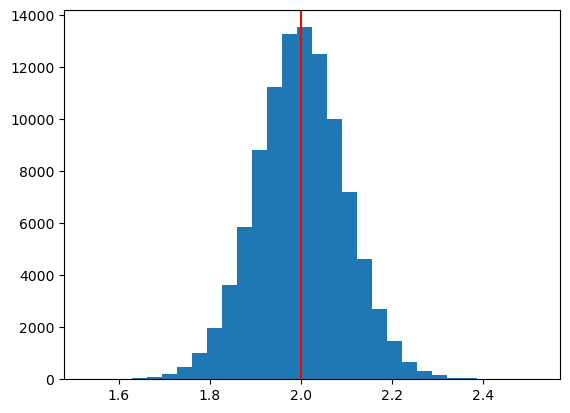

In [47]:
plt.hist(b1hat,bins=30)
plt.axvline(x=b1,color='red')
pass

`b1`の真の値`2.0`を中心に概ね左右対象に分布していることが分かる。

次に分布（ヒストグラム）のカーネル密度推定をおこなうために，`scipy.stats`にある`gaussian_kde`を使う。

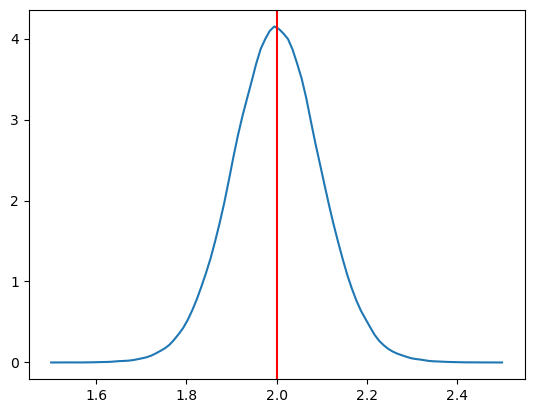

In [48]:
x=np.linspace(1.5,2.5,100)  # 図を作成するために1.5から2.5までの横軸の値を設定
kde_model=gaussian_kde(b1hat)  # カーネル密度推定を使いb1hatの分布を推定

plt.plot(x, kde_model(x))  # 誤差項の分布をプロット
plt.axvline(x=b1,color='red')  # 母集団のパラメータ
pass

２つの図を重ねる。

（注意）ヒストグラムの縦軸は頻度である。一方，カーネル密度推定の場合，曲線の下の面積が１になるように縦軸が設定されている。ヒストグラムの縦軸をカーネル密度推定に合わせるために`density=True`のオプションを加える。

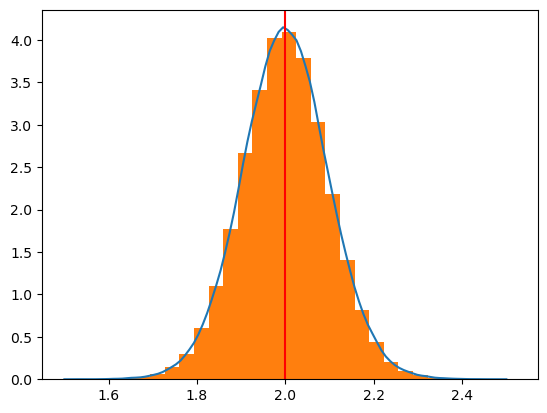

In [49]:
x=np.linspace(1.5,2.5,100)
kde_model=gaussian_kde(b1hat)

plt.plot(x, kde_model(x))
plt.hist(b1hat,bins=30, density=True)
plt.axvline(x=b1,color='red')
pass

＜Give it a try!＞
* 標本の大きさ`n`を30、100、500の３つのケースでシミュレーションをおこない、それぞれのカーネル密度推定を重ねて１つの図を作成しなさい。
* $\hat{\beta}_0$と$\hat{\beta}_2$の分布も図示しなさい。
* `n`を変化させて違いを確かめなさい。
* `N`を変化させて違いを確かめなさい。

## シミュレーション：多重共線性

(sec:9-vif)=
## シミュレーション：多重共線性

### 説明

多重共線性が高くなると，パラメータの推定値の正確性が低下する（即ち、パラメータの標準誤差$\text{se}\left(\hat{\beta}_j\right)$が大きくなる）。この点を確認するためにパラメータの分散の推定値にある

$$
\frac{1}{1-R_j^2}
$$

を利用する。これは
**分散拡大因子（variance inflation factor）**
と呼ばれる。以下では`vif`と呼ぶ。この値が１０以上になる説明変数どうしを使うと多重共線性の可能性が高いといわれる。

例として回帰分析`res_1`を考える。

### 方法１：手計算

まず説明変数だけから構成される`DataFrame`を作成する。

In [50]:
wage1_vif = wage1.loc[:,['educ','tenure','exper']]

`corr()`は相関係数を返すメソッドであり，そこから`.to_numpy()`を使いデータを`Numpy`の`array`として取り出す。

In [51]:
mc = wage1_vif.corr().to_numpy()

* 上でも使った`linalg.inv()`は、`NumPy`にある`linalg`サブパッケージの関数であり、逆行列を返す。
* `diagonal()`は対角成分を返すメソッドであり，それが`vif`である。

In [52]:
vif_manual = np.linalg.inv(mc).diagonal()
vif_manual

array([1.11277075, 1.34929556, 1.47761777])

変数名と一緒に表示するために次のように`Series`として表示する。

In [53]:
pd.Series(vif_manual, index=wage1_vif.columns)

educ      1.112771
tenure    1.349296
exper     1.477618
dtype: float64

次に上の計算を関数にまとめる。

In [54]:
def my_vif(dataframe):
    mc = dataframe.corr().to_numpy()
    vif = np.linalg.inv(mc).diagonal()
    return pd.Series(vif_manual, index=dataframe.columns)

my_vif(wage1_vif)

educ      1.112771
tenure    1.349296
exper     1.477618
dtype: float64

### 方法２：`statsmodels`

`statsmodels`にある`variance_inflation_factor`を使い`vif`を計算することもできる。

必ず**定数項を含む**説明変数だけから構成される`DataFrame`を作成する。

In [55]:
wage1_vif['Intercept'] = 1.0

In [56]:
for i in range(len(wage1_vif.columns)-1):  # 定数項は無視するために-1
    name = wage1_vif.columns[i]
    vif_val = vif(wage1_vif.to_numpy(), i)
    print(f'{name : <10}{vif_val}')

educ      1.1127707502838835
tenure    1.3492955605611776
exper     1.4776177726317783


定数項は考えなくて良い。

（コードの説明）
* `f-string`を使っている。
* `{name : <10}`は、`name`の値を代入し、`10`という幅の中で左寄せしている。
* `{vif_val}`は、`vif_val`の値を代入している。

### シミュレーション

シミュレーションをおこない、多重共線性により`OLS`推定量の標準誤差が上昇し推定量の正確性が損なわれることを確認する。

シミュレーションでは以下の回帰式を使う。

$$y=\beta_0+\beta_1x_1+\beta_2x_2+u$$

母集団の係数の値を以下のように設定する
* $\beta_0=1.0$
* $\beta_1=2.0$
* $\beta_2=3.0$

シミュレーションの関数を作成する。
* 引数
    * `n`：標本の大きさ
    * `N`：標本数（ループの回数）
    * `m`：２つの説明変数の共分散
    * `b0`：定数項（デフォルトは`1.0`と設定）
    * `b1`：スロープ係数（デフォルトは`2.0`と設定）
    * `b2`：スロープ係数（デフォルトは`3.0`と設定）
* 返り値
    * $\hat{\beta}_i$，$i=0,1,2$の推定値のリスト
    
（コメント）

* `@njit`を使いたいところだが，`Numpy`の`random.multivariate_normal()`が`Numba`に対応していないため`scipy.stats`の `multivariate_normal.rvs()`を使う。`np.random.normal()`を使って二変量正規分布からの値とする方法もあるが，ここでは簡単化を重視する。
* `ols`は係数の推定値だけではなく他の多くの統計値も自動的に計算するため一回の計算に比較的に長い時間を要する。計算の速度を少しでも早めるために下の関数の中では`ols`は使わず`Numpy`の関数を使いOLS推定値を計算する。

In [57]:
def sim_multi(n, N, m, b0=1.0, b1=2.0, b2=3.0):  # n=標本の大きさ, N=標本数, m=共分散
    
    # ２つのx1,x2の共分散を設定
    rv_mean = [4, 1]  # x1, x2の平均
    # x1, x2の共分散行列
    rv_cov = [[1.0, m],    # 全ての変数の分散は１（対角成分）
              [m, 1.0]]  # Cov(x1,x2)=m
    
    # 推定値を入れる空のarray
    b0hat_arr = np.zeros(N)
    b1hat_arr = np.zeros(N)
    b2hat_arr = np.zeros(N)
    
    c = np.ones(n)  # 定数項
    
    for i in range(N):  # N 回のループ
        
        # x1, x2の値の抽出
        rv = multivariate_normal.rvs(rv_mean, rv_cov, size=n)  # x1, x2,をnセット抽出
        x1 = rv[:,0]  # 説明変数
        x2 = rv[:,1]  # 説明変数

        u = np.random.randn(n)  # 標準正規分布
        y = b0 + b1*x1 + b2*x2 + u  # 説明変数
        
        X = np.stack((c,x1,x2),axis=1)  # 説明変数の行列
        bhat = np.linalg.inv((X.T)@X)@(X.T)@y  # OLS推定
        
        b0hat_arr[i] = bhat[0]  # b0hat_arrへの追加
        b1hat_arr[i] = bhat[1]  # b1hat_arrへの追加
        b2hat_arr[i] = bhat[2]  # b2hat_arrへの追加

    return b0hat_arr, b1hat_arr, b2hat_arr # 返り値の設定

シミュレーションの開始

In [58]:
# 多重共線性が弱いケース 
b0hat_weak, b1hat_weak, b2hat_weak = sim_multi(30, 10_000, m=0.1)

# 多重共線性が強いケース 
b0hat_strong, b1hat_strong, b2hat_strong = sim_multi(30, 10_000, m=0.9)

$\hat{\beta}_1$の分布の図示

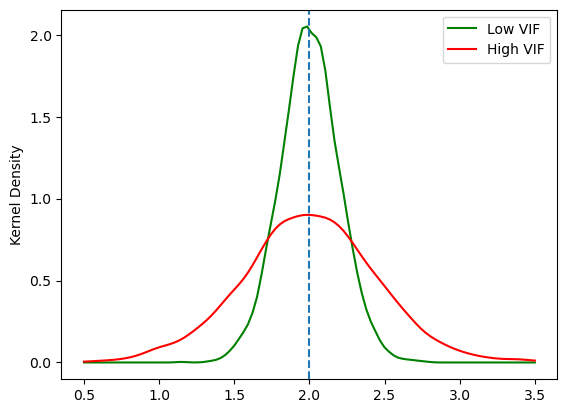

In [59]:
xx=np.linspace(0.5,3.5,num=100)  # 図を作成するために横軸の値を設定

# 多重共線性が弱いケース
kde_model_weak=gaussian_kde(b1hat_weak)  # OLS推定量のカーネル密度関数を計算

# 多重共線性が強いケース
kde_model_strong=gaussian_kde(b1hat_strong)

plt.plot(xx, kde_model_weak(xx), 'g-', label='Low VIF')  # OLS推定量の分布プロット
plt.plot(xx, kde_model_strong(xx),'r-', label='High VIF')  # IV推定量の分布プロット
plt.axvline(x=b1,linestyle='dashed')
plt.ylabel('Kernel Density')  # 縦軸のラベル
plt.legend()  # 凡例
pass

多重共線性が強いと推定値の分布は，真の値（$\beta_1=$
`2.0`）の周辺で低くなり左右に広がっている。推定値の正確性が低下することを示している。$\hat{\beta}_1$の分散を計算してみよう。

In [60]:
np.var(b1hat_weak), np.var(b1hat_strong)

(0.03953700713988302, 0.20246929652754997)

＜Give it a try!＞

以下のシミュレーションをおこない，違いは何か確認しなさい。
1. $\hat{\beta}_0$と$\hat{\beta}_2$の分布も図示しなさい。
1. `n`を変化させて違いを確かめなさい。
1. `N`を変化させて違いを確かめなさい。
1. `sim_multi`を書き換えて$\hat{\beta}_1$と$\hat{\beta}_2$の標準誤差をプロットし問4のそれぞれの平均を計算しなさい。（ヒント：推定結果の属性`bse`を使う）

問4の答え：$+$を押すと答えが表示される。

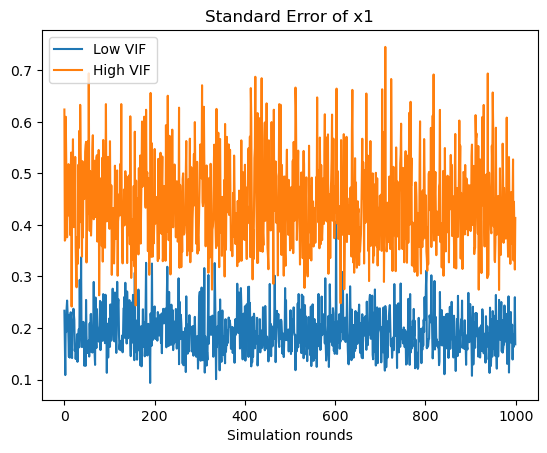

In [61]:
def sim_se(n, N, m, b0=1.0, b1=2.0, b2=3.0):  # n=標本の大きさ, N=標本数, m=共分散
    
    rv_mean = [4, 1]  # x1, x2の平均
    # x1, x2の共分散行列
    rv_cov = [[1.0, m],    # 全ての変数の分散は１（対角成分）
              [m, 1.0]]  # Cov(x1,x2)=m
    
    # 推定値を入れるarray
    se_x1_arr = np.zeros(N)
    se_x2_arr = np.zeros(N)

    for i in range(N):  # N 回のループ
        
        rv = multivariate_normal.rvs(rv_mean, rv_cov, size=n)  # x1, x2,をnセット抽出
        x1 = rv[:,0]  # 説明変数
        x2 = rv[:,1]  # 説明変数
        X = np.stack([np.ones(n),x1,x2],axis=1)  # 説明変数の行列    
        
        u = np.random.normal(loc=0, scale=1, size=n)  # 誤差項（標準正規分布）
        y = b0 + b1*x1 + b2*x2 + u  # 説明変数

        bhat = np.linalg.inv((X.T)@X)@(X.T)@y # 係数の推定値
        yhat = X@bhat  # yの予測値
        uhat = y-yhat  # 残差
        rss = (uhat.T)@uhat  # 残差平方和
        sigma2 = rss/(n-3)  # 回帰の残差（不偏）分散 
        XTX_1 = np.linalg.inv(X.T@X)  # moment matrix
        variance = sigma2*np.diag(XTX_1)  # bの分散
        se = np.sqrt(variance)  # bの標準誤差
        
        se_x1_arr[i] = se[1]  # arrayに追加
        se_x2_arr[i] = se[2]  # array追加
        
    return se_x1_arr, se_x2_arr # 返り値の設定


# 多重共線性が弱いケース 
se_x1_weak, se_x1_weak = sim_se(30,1000,m=0.1)

# 多重共線性が強いケース 
se_x1_strong, se_x1_strong = sim_se(30,1000,m=0.9)


plt.plot(se_x1_weak, label='Low VIF')
plt.plot(se_x1_strong, label='High VIF')
plt.title('Standard Error of x1')
plt.xlabel('Simulation rounds')
plt.legend()
pass

問5の答え：$+$を押すと答えが表示される。

In [62]:
sum(se_x1_weak)/len(se_x1_weak), sum(se_x1_strong)/len(se_x1_strong)

# 次のコードでもOK
# np.array(se_x1_weak).mean(), np.array(se_x1_strong).mean()

(0.19201842019800944, 0.44163756153259215)

### 図を使ってチェック

多重共線性は説明変数間の相関が高いと発生するが，ここでは相関度を図を使ってチェックする。色々な方法があるが，以下では２つ紹介する。
1. `pandas`の関数`scatter_matrix`を使う方法
1. `seaborn`というパッケージの関数`pairplot`を使う方法

#### `pandas`を使う方法

まずコードの中で`matplotlib`を明示的に導入せずに`pandas`のみを使い図示する方法を紹介する。こちらの方が簡単と感じるかもしれない。散布図を描いてみる。

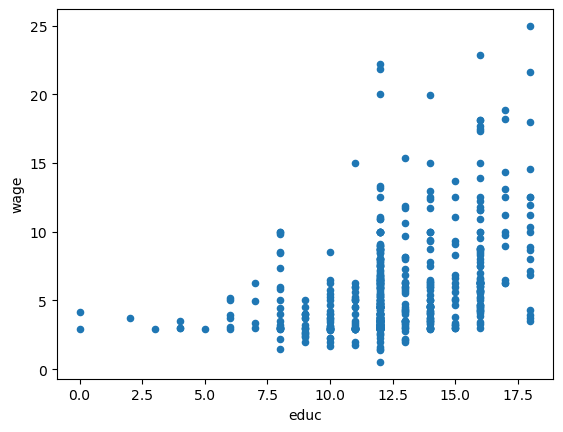

In [63]:
wage1.plot.scatter('educ','wage')
pass

`pandas`の`DataFrame`や`Series`には図を作成するメソッド`plot()`が用意されている（裏では`matplotlib`が動いている）。例えば，`wage1`にある`educ`のヒストグラムであれば次のコードで図示することができる。
```
wage1['educ'].plot(kind='hist')

もしくは

wage1['educ'].plot.hist()
```
また`educ`と`wage`の散布図は次のコードで描くことができる。
```
wage1.plot('educ','wage',kind='scatter')

もしくは

wage1.plot.scatter('educ','wage')
```

また１つの`DataFrame`にある複数列データを使い，複数の図を並べることも可能である。興味がある人は[このリンク](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html)を参照しよう。

---
変数の相関度をチェックするために`pandas.plotting`の`scatter_matrix`を使う。このモジュールは`DataFrame`を引数とする。

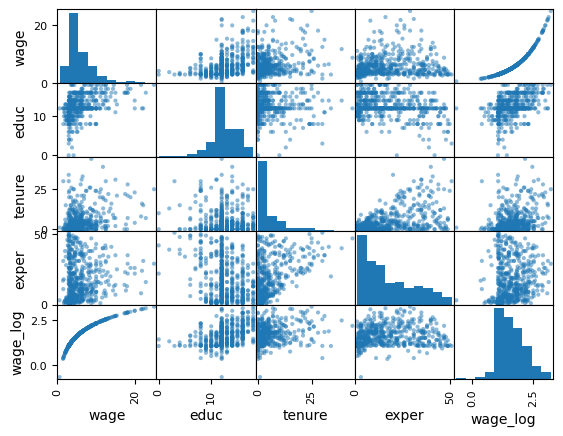

In [64]:
scatter_matrix(wage1)
pass

横軸と縦軸のラベルを確認すること。対角線上はそれぞれの変数のヒストグラム，対角線以外の図は縦横のペアの変数の散布図となっており，相関度をある程度目視で確認できる。

---
次に主なオプションとして２つを紹介する。
1. 図の大きさは`figsize=(9, 6)`で指定する。この例では`9`が横幅，`6`が縦幅である。 
1. `diagonal='kde'`を指定すると対角線上のヒストグラムをカーネル密度推定に変更できる。

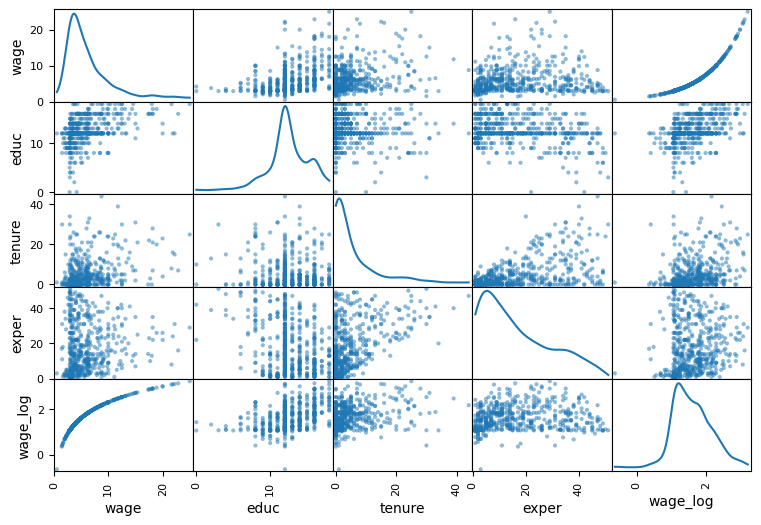

In [65]:
scatter_matrix(wage1, figsize=(9, 6), diagonal='kde')
pass

次に相関係数を簡単に計算する方法を紹介する。`DataFrame`のメソッド`corr()`を使うと変数の相関係数を`DataFrame`として返す。

In [66]:
mat = wage1.corr()
mat

,wage,educ,tenure,exper,wage_log
wage,1.000000,0.405903,0.346890,0.112903,0.937062
educ,0.405903,1.000000,-0.056173,-0.299542,0.431053
tenure,0.346890,-0.056173,1.000000,0.499291,0.325538
exper,0.112903,-0.299542,0.499291,1.000000,0.111373
wage_log,0.937062,0.431053,0.325538,0.111373,1.000000


上の図と相関係数の値を見比べて，概ねどのような関係にあるのかを確かめよう。

#### `seaborn`を使う方法

`seaborn`というパッケージを使うとより「見栄えがする」図を描くことができる。`seaborn`については[このリンク](https://seaborn.pydata.org)を参照しよう。`seaborn`は`sns`としてインポートするのが慣例である。

まず上で`DataFrame`のメソッド`corr()`を使い変数の相関係数を計算したが，`seaborn`の`heatmap()`関数を使うと相関係数を色に変換してより見やすい表示となる。

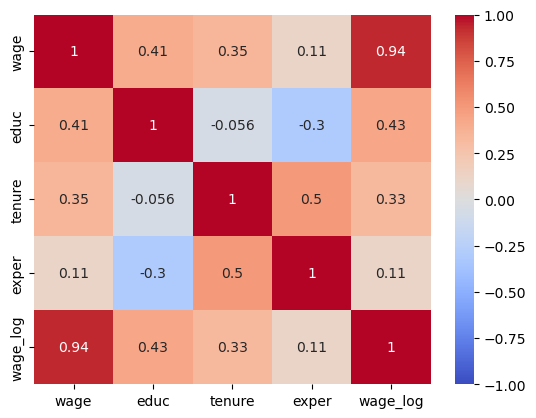

In [67]:
sns.heatmap(mat, vmin=-1, annot=True, cmap='coolwarm')
pass

赤はプラス，青はマイナスを示し，色の濃淡は絶対値に連動している。ここで使った３つのオプション（設定しなくても良い）の説明する。
* `vmin`：右の縦長の棒は表示される範囲を示すが，その最低値を`-1`にする（デフォルトは自動で設定）
    * 最高値を設定する`vmax`もあるが，`.corr()`の対角成分は`1`なので設定する必要はない。
* `annot`は相関係数を表示する（デフォルトは`False`）
* `cmap`は色を設定する（デフォルトは`None`）

`seaborn`には`matplotlib`の相関度をチェックする`scatter_matrix`関数に対応する`pairplot`があり，より使い勝手が良いと感じるかもしれない。

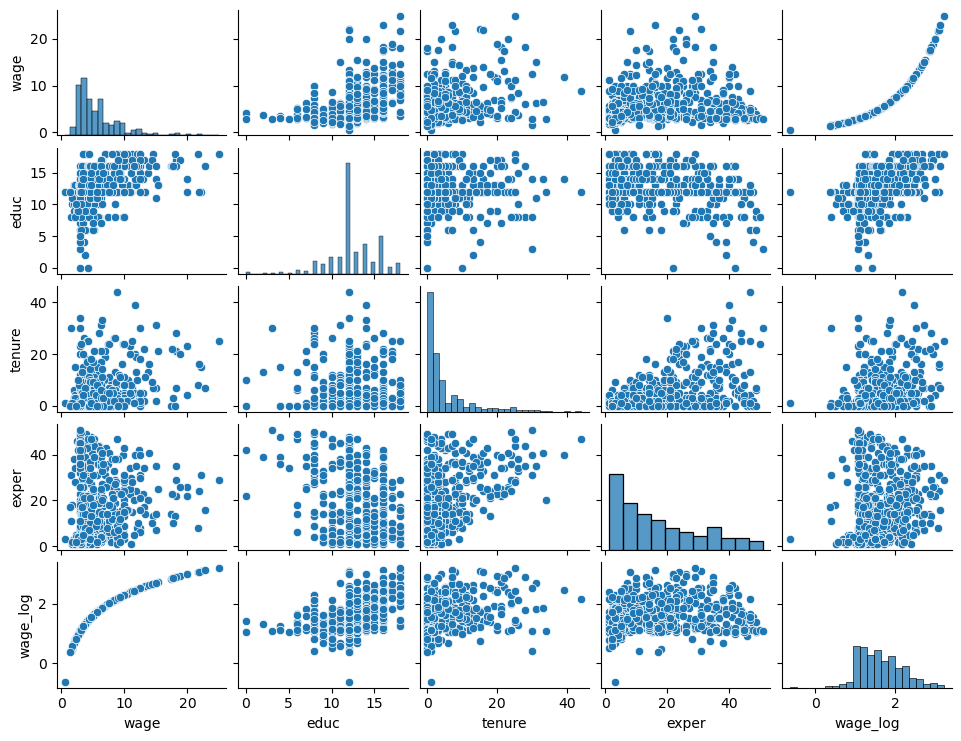

In [68]:
sns.pairplot(wage1, height=1.5, aspect=1.3)
pass

図の解釈は`pandas`の場合と同じである。

`pairplot()`の主な引数：
1. それぞれの図（ファセット）のサイズ
    * `height`は高さを指定
    * 横幅は`aspect`$\times$`height`で設定する。
1. 対角線上のヒストグラムをカーネル密度推定に変更する場合は`diag_kind=kde`と指定する。
1. `kind='reg'`を追加すると，散布図に回帰直線が追加され相関度の確認がより簡単になる。

`seaborn`の回帰分析に関係するプロットについては[このリンク](https://seaborn.pydata.org/tutorial/regression.html#regression-tutorial)が役立つだろう。